# Setup


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q kaggle
!pip install split-folders

In [8]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle (3).json to kaggle (3).json


{'kaggle (3).json': b'{"username":"abdurrayman","key":"07114cf39a4f1956be0923fdc6494af3"}'}

In [9]:
!mkdir -p ~/.kaggle


In [10]:
!cp kaggle.json ~/.kaggle/


In [11]:
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
#!mv "kaggle (3).json" kaggle.json
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json


cp: cannot create regular file '/root/.kaggle/': Not a directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [12]:
!kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset


Dataset URL: https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset
License(s): copyright-authors
100% 28.0M/28.0M [00:03<00:00, 16.0MB/s]
100% 28.0M/28.0M [00:03<00:00, 9.19MB/s]


## Imports

In [13]:
import tensorflow as tf
import zipfile
import os
import splitfolders
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Data


In [14]:


zip_file_path = 'alzheimer-mri-dataset.zip'
extract_dir = 'final'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [15]:
splitfolders.ratio(extract_dir + '/Dataset', output="final", seed=1345, ratio=(.8, 0.1, 0.1))


Copying files: 6400 files [00:00, 7812.31 files/s]


In [16]:
#rm -r /content/final

## Data Loading


In [17]:
IMG_HEIGHT = 128
IMG_WIDTH = 128


In [18]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/final/train",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/final/val",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/final/test",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=64
)

Found 5119 files belonging to 4 classes.
Found 639 files belonging to 4 classes.
Found 642 files belonging to 4 classes.


## Data Exploration


['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


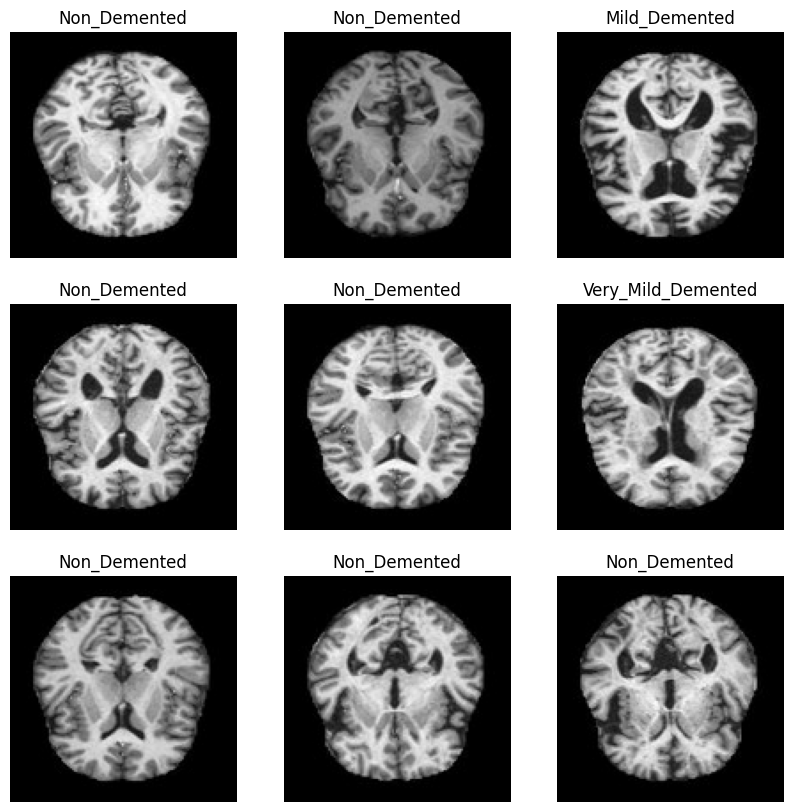

In [19]:
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

# Model


### Model Building


In [20]:
model = keras.models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer="he_normal"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer="he_normal"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Dropout(0.20),

    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer="he_normal"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])


In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cnn_model.keras', save_best_only=True, monitor='val_loss')


## Model Training


In [23]:
model.summary()
hist = model.fit(train_ds, validation_data=val_ds, epochs=25, batch_size=64, verbose=1,callbacks=[early_stopping, model_checkpoint]
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,129,380 (8.12 MB)

 Trainable params: 2,129,380 (8.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.4684 - loss: 1.2506 - val_accuracy: 0.6056 - val_loss: 0.9185
Epoch 2/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.5618 - loss: 0.9316 - val_accuracy: 0.6338 - val_loss: 0.8270
Epoch 3/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6269 - loss: 0.8318 - val_accuracy: 0.6604 - val_loss: 0.7686
Epoch 4/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6943 - loss: 0.7301 - val_accuracy: 0.7574 - val_loss: 0.6062
Epoch 5/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7499 - loss: 0.6064 - val_accuracy: 0.8013 - val_loss: 0.5093
Epoch 6/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8074 - loss: 0.4785 - val_accuracy: 0.8654 - val_loss: 0.4066
Epoch 7/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8651 - loss: 0.3524 - val_accuracy: 0.8998 - val_loss: 0.2838
Epoch 8/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8901 - loss: 0.2922 - val_accuracy: 0.8748 -

## Model Evaluation


In [24]:
model.save('/content/best_cnn_model.keras')
loaded_ann_model = keras.models.load_model('/content/best_cnn_model.keras')


In [25]:
loss, accuracy = model.evaluate(test_ds)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.9846 - loss: 0.0402


# Testing


## Metrics


In [ ]:
get_ac = hist.history['accuracy']
get_los = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

In [ ]:
epochs = range(len(get_ac))


## Plotting

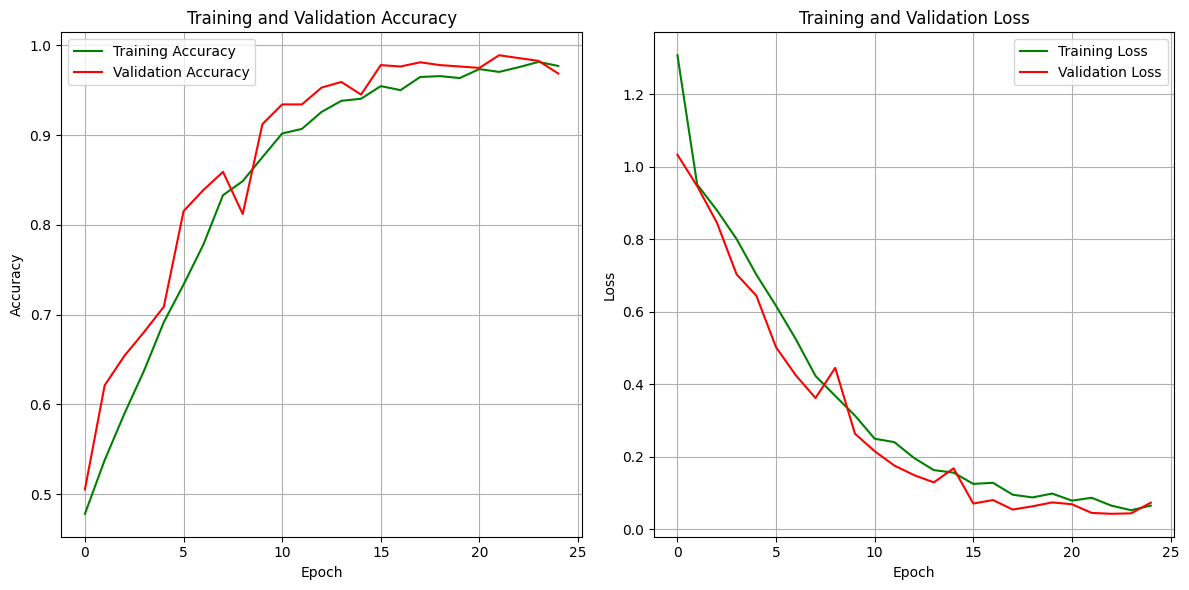

In [ ]:
plt.figure(figsize=(12, 6))
# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)  # Change to 1x2 grid
plt.plot(epochs, get_ac, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)  # Add gridlines

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)  # Change to 1x2 grid
plt.plot(epochs, get_los, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)  # Add gridlines

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_ds)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9808 - loss: 0.0738


## Collect predictions and actual labels


In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())  # Actual labels
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted labels

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


In [ ]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

## Calculate Accuracy, Precision, Recall, and F1-Score


In [ ]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9782
Precision: 0.9790
Recall: 0.9782
F1 Score: 0.9781


## Confusion Matrix


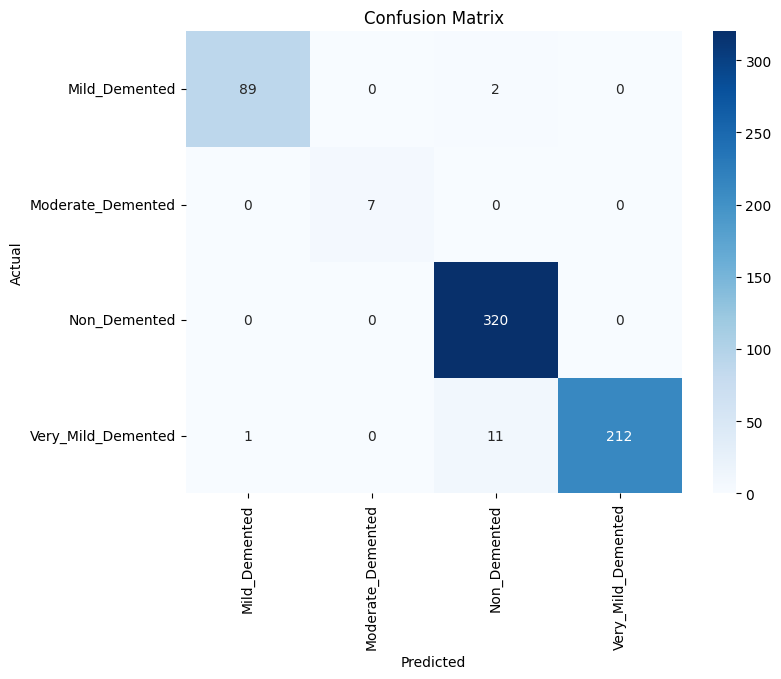

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## Classification Report


In [ ]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))



Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.99      0.98      0.98        91
 Moderate_Demented       1.00      1.00      1.00         7
      Non_Demented       0.96      1.00      0.98       320
Very_Mild_Demented       1.00      0.95      0.97       224

          accuracy                           0.98       642
         macro avg       0.99      0.98      0.98       642
      weighted avg       0.98      0.98      0.98       642

